In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import contractions
import re
import unicodedata

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from plotnine import *
%matplotlib inline

### Join and clean dfs

In [120]:
# join dfs
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
dfs = [pd.read_json(f'../../data/ea_forum/{yr}/{yr}_data.json') for yr in years]
df = pd.concat(dfs)
df.head()

,date,title,author,num_comments,num_karma,content
0,2013-06-21,Cheerfully,Julia_Wise,22 comments,37.0,"<div class=""PostsPage-postContent""><div><p>Whe..."
1,2013-05-13,What is effective altruism?,William_MacAskill,16 comments,9.0,"<div class=""PostsPage-postContent""><div><p><im..."
2,2013-08-19,Preventing human extinction,Peter_Singer,8 comments,12.0,"<div class=""PostsPage-postContent""><div><p><em..."
3,2013-09-03,Efficient charity: do unto others...,Scott_Siskind,6 comments,15.0,"<div class=""PostsPage-postContent""><div><p>Ima..."
4,2013-11-05,A Long-run perspective on strategic cause sele...,Carl_Shulman,29 comments,8.0,"<div class=""PostsPage-postContent""><div><p><em..."


In [121]:
df.isna().sum()

date             9
title            9
author          15
num_comments     9
num_karma        9
content          9
dtype: int64

In [122]:
df = df[~df['content'].isna()]
df['author'] = df['author'].fillna('anonymous')

In [123]:
# remove recent posts
df = df[df['date']<'04-15-2020']

In [124]:
def extract_text(content):
    soup = BeautifulSoup(content, 'html.parser')
    #remove style tags:
    for tag in soup.find_all('style'):
        tag.replaceWith('')
    #remove all other tags
    text = soup.get_text()  
    #fix unicode
    text = unicodedata.normalize("NFKD", text)    
    #replace line breaks
    text = text.replace('\n', ' ')
    return text
    

In [125]:
df['content'] = df['content'].apply(extract_text)

In [126]:
df.head()

,date,title,author,num_comments,num_karma,content
0,2013-06-21,Cheerfully,Julia_Wise,22 comments,37.0,"When I was younger, I was extremely struck by ..."
1,2013-05-13,What is effective altruism?,William_MacAskill,16 comments,9.0,Most forms of do-gooding start out with a Wh...
2,2013-08-19,Preventing human extinction,Peter_Singer,8 comments,12.0,"Co-authored by Nick Beckstead, Peter Singer, a..."
3,2013-09-03,Efficient charity: do unto others...,Scott_Siskind,6 comments,15.0,Imagine you are setting out on a dangerous exp...
4,2013-11-05,A Long-run perspective on strategic cause sele...,Carl_Shulman,29 comments,8.0,Co-written by Nick Beckstead and Carl Shulman ...


In [127]:
df['num_comments'] = df['num_comments'].str.replace(' comments', '').str.replace(' comment', '').str.replace('No', '0').astype(int)
df['num_karma'] = df['num_karma'].astype(int)

In [129]:
df.to_csv('../../data/ea_forum/cleaned_data_eaforum.csv')

### EDA: Comments

In [130]:
count_posts = pd.DataFrame(df.groupby(df['date'].dt.year).count()['title']).reset_index().rename(columns = {'title': 'count', 'date': 'year'})
count_posts = count_posts[count_posts['year']<2020]

In [131]:
p = (ggplot(count_posts, aes(x='year', y='count'))
 +geom_col(fill='red', color='black') 
 +theme_minimal()
 +theme(figure_size=(3,3), axis_text_x = element_text(angle=90), plot_background=element_rect(fill='white'))
 +scale_x_continuous(breaks=count_posts['year'].to_list())
 +xlab('')
 +ylab('Number of posts')    
)
p.save(filename='../../out/images/posts_year.jpeg', dpi=300)

C:\Users\light\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\light\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ../../out/images/posts_year.jpeg
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [132]:
posts_comments = df.sort_values(by='num_comments', ascending=False)[['date', 'title', 'author', 'num_comments']].head(10)
posts_comments

,date,title,author,num_comments
705,2019-04-23,Long-Term Future Fund: April 2019 grant recomm...,Habryka,240
14,2017-10-26,Why & How to Make Progress on Diversity & Incl...,Kelly_Witwicki,235
504,2019-11-15,"I'm Buck Shlegeris, I do research and outreach...",Buck,231
6,2016-10-24,Concerns with Intentional Insights,Jeff_Kaufman,186
620,2019-02-26,After one year of applying for EA jobs: It is ...,EA applicant,182
38,2020-01-16,Growth and the case against randomista develop...,HaukeHillebrandt,168
70,2014-09-15,Open Thread,RyanCarey,163
186,2017-11-11,An Exploration of Sexual Violence Reduction fo...,Kathy_Forth,156
71,2014-10-22,Should Giving What We Can change its Pledge?,Michelle_Hutchinson,144
364,2019-09-03,Are we living at the most influential time in ...,William_MacAskill,140


In [133]:
posts_karma = df.sort_values(by='num_karma', ascending=False)[['date', 'title', 'author', 'num_karma']].head(10)
posts_karma

,date,title,author,num_karma
620,2019-02-26,After one year of applying for EA jobs: It is ...,EA applicant,285
38,2020-01-16,Growth and the case against randomista develop...,HaukeHillebrandt,269
40,2020-01-13,EAF’s ballot initiative doubled Zurich’s devel...,Jonas Vollmer,254
398,2019-09-26,Some personal thoughts on EA and systemic change,Carl_Shulman,183
364,2019-09-03,Are we living at the most influential time in ...,William_MacAskill,174
736,2019-06-02,Is EA Growing? EA Growth Metrics for 2018,Peter_Hurford,168
635,2019-03-07,SHIC Will Suspend Outreach Operations,cafelow,165
352,2019-08-20,List of ways in which cost-effectiveness estim...,saulius,155
249,2019-06-20,Information security careers for GCR reduction,ClaireZabel,153
811,2019-08-14,Ask Me Anything!,William_MacAskill,150


In [136]:
posts_comments.to_csv('../../out/tables/posts_comments.csv', index=False)
posts_karma.to_csv('../../out/tables/posts_karma.csv', index=False)

In [140]:
num_posts = df.groupby('author')['title'].count().sort_values(ascending=False)
num_posts.head()

author
Aaron Gertler    87
Milan_Griffes    83
Peter_Hurford    74
RyanCarey        66
Tom_Ash          58
Name: title, dtype: int64

In [143]:
df[df['author'].map(num_posts)>1].groupby('author')['num_karma'].mean().sort_values(ascending=False).head()

author
Buck               92.200000
Jonas Vollmer      77.000000
Luisa_Rodriguez    74.714286
saulius            73.500000
sbehmer            73.000000
Name: num_karma, dtype: float64

In [139]:
df.groupby('author')['num_karma'].mean().sort_values(ascending=False).head()

author
EA applicant    285.0
eca             140.0
IvanVendrov     117.0
leopold         117.0
rosehadshar     109.0
Name: num_karma, dtype: float64

In [13]:
(df.groupby('author')['num_comments'].sum()/df.groupby('author')['num_comments'].count()).sort_values(ascending=False)

author
EA applicant       182.0
Kelly_Witwicki     119.0
throwaway           96.0
Matthew_Barnett     82.0
AlyssaVance         80.0
                   ...  
Pigman               0.0
David_Goll           0.0
curiousepic          0.0
mattvdm              0.0
JDBauman             0.0
Name: num_comments, Length: 744, dtype: float64

### Clean text for wordcloud

In [144]:
all_text = df['content'].sum()
#expand contractions
all_text = ' '.join([contractions.fix(w) for w in all_text.split()])

In [145]:
# split into words
tokens = word_tokenize(all_text)
# convert to lower case
tokens = [w.lower() for w in tokens]
# remove punctuation
tokens = [w for w in tokens if w not in string.punctuation] 
# filter out stop words
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
#remove numbers
tokens = [w for w in tokens if not re.match('.*\d.*', w)]
#remove https and wwws
tokens = [w for w in tokens if not re.match('.*www.*', w)]
tokens = [w for w in tokens if not re.match('.*http.*', w)]

In [146]:
cleaned_text = ' '.join(tokens)

In [147]:
len(tokens)

2595195

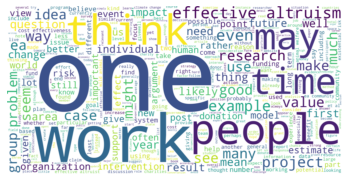

In [148]:
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white', width= 4000, height = 2000, max_words = 400).generate(cleaned_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [149]:
wordcloud.to_file('../../out/wordclouds/eaforum_wordcloud.jpg')

### Make BOW for wordcloud in R

In [21]:
# use cleaned text to make bag of words along with ssc
with open('../../data/ssc/ssc_for_BOW.txt', 'r+', encoding='utf-8') as f:
    ssc_cleaned = f.read()

In [22]:
len(cleaned_text)

20198740

In [23]:
corpus = [cleaned_text, ssc_cleaned]
vectorizer = CountVectorizer(analyzer = 'word', lowercase=False, stop_words=None)
bow = vectorizer.fit_transform(corpus)

In [25]:
bow_df = pd.DataFrame(bow.toarray(), index=['ea_forum', 'ssc'], columns=vectorizer.get_feature_names())

In [28]:
bow_df = bow_df.T
bow_df.to_csv('../../data/eaforum_scc_BOW.csv')

### Make GPT2 text

In [20]:
with open('../../data/ea_forum/eaforum_for_gpt2.txt', 'w+', encoding='utf-8') as f:
    for _, row in df.iterrows():
        f.write(row['title'] + '\n')
        f.write(row['content'] + '\n')